In [151]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [81]:
class SegmentDataSet():
    def __init__(self):
        self.types = ['F', 'U', 'SP', 'LP']
        self.file_paths = {typ: f'D:\ebg408\data\segment_data\{typ}_data' for typ in self.types}
        self.file_name_list = {typ: os.listdir(file_path) for typ, file_path in self.file_paths.items()}
        self.F_data = {file_name: pd.read_csv(os.path.join(self.file_paths['F'], file_name)) for file_name in self.file_name_list['F']}
        self.U_data = {file_name: pd.read_csv(os.path.join(self.file_paths['U'], file_name)) for file_name in self.file_name_list['U']}
        self.SP_data = {file_name: pd.read_csv(os.path.join(self.file_paths['SP'], file_name)) for file_name in self.file_name_list['SP']}
        self.LP_data = {file_name: pd.read_csv(os.path.join(self.file_paths['LP'], file_name)) for file_name in self.file_name_list['LP']}
        self.all_data = {**self.F_data, **self.U_data, **self.SP_data, **self.LP_data}

In [211]:
data = SegmentDataSet()

In [92]:
data.all_data[data.file_name_list['F'][0]]

,type,no.,group.no,player.no,Trials,StockPrice,Cash,Stock,TotalAsset,Decision,opp_Cash,opp_Stock,opp_TotalAsset,opp_Decision
0,flat,100,22,43,1,100,10000,10,11000,buy,10000,10,11000,sell
1,flat,100,22,43,2,100,9900,11,11000,no trade,10100,9,11000,sell
2,flat,100,22,43,3,97,9900,11,10967,sell,10200,8,10976,sell
3,flat,100,22,43,4,93,9997,10,10927,no trade,10297,7,10948,buy
4,flat,100,22,43,5,96,9997,10,10957,sell,10204,8,10972,no trade
5,flat,100,22,43,6,94,10093,9,10939,buy,10204,8,10956,no trade
6,flat,100,22,43,7,97,9999,10,10969,no trade,10204,8,10980,sell
7,flat,100,22,43,8,95,9999,10,10949,no trade,10301,7,10966,no trade
8,flat,100,22,43,9,95,9999,10,10949,no trade,10301,7,10966,no trade
9,flat,100,22,43,10,95,9999,10,10949,no trade,10301,7,10966,no trade


In [79]:
def upper_bound(df):
    # filters
    maxprice = df.loc[:,'StockPrice'] == max(df.loc[:,'StockPrice'])
    action = df.loc[:,'Decision'] != 'buy'
    # TODO
    # 之後就不用.shift，直接有現成的lag_action可以用
    lag_action = df.loc[:,'Decision'].shift(1) == 'buy'

    # get filtered df
    matched_df = df[maxprice & action & lag_action]
    upper_bounds = [price for price in matched_df.loc[:, 'StockPrice']]

    # return results
    if upper_bounds:
        return upper_bounds
    else:
        return None

In [93]:
def lower_bound(df):
    # filters
    minprice = df.loc[:, 'StockPrice'] == min(df.loc[:,'StockPrice'])
    action = df.loc[:, 'Decision'] != 'sell'
    # TODO
    # 之後就不用.shift，直接有現成的lag_action可以用
    lag_action = df.loc[:, 'Decision'].shift(1) == 'sell'
    stock = df.loc[:, 'Stock'] != 0

    # get filtered df
    matched_df = df[minprice & action & lag_action & stock]
    lower_bounds = [price for price in matched_df.loc[:, 'StockPrice']]

    # return results
    if lower_bounds:
        return lower_bounds
    else:
        return None

In [220]:
class UpperLowerBounds():
    def __init__(self, dataset):
        self.upper_lower_bounds = self.get_result(dataset)

    def upper_bound(self, df):
        # filters
        maxprice = df.loc[:,'StockPrice'] == max(df.loc[:,'StockPrice'])
        action = df.loc[:,'Decision'] != 'buy'
        # TODO
        # 之後就不用.shift，直接有現成的lag_action可以用
        lag_action = df.loc[:,'Decision'].shift(1) == 'buy'

        # get filtered df
        matched_df = df[maxprice & action & lag_action]
        upper_bounds = [price for price in matched_df.loc[:, 'StockPrice']]

        # return results
        return upper_bounds
    
    def lower_bound(self, df):
        # filters
        minprice = df.loc[:, 'StockPrice'] == min(df.loc[:,'StockPrice'])
        action = df.loc[:, 'Decision'] != 'sell'
        # TODO
        # 之後就不用.shift，直接有現成的lag_action可以用
        lag_action = df.loc[:, 'Decision'].shift(1) == 'sell'
        stock = df.loc[:, 'Stock'] != 0

        # get filtered df
        matched_df = df[minprice & action & lag_action & stock]
        lower_bounds = [price for price in matched_df.loc[:, 'StockPrice']]

        # return results
        return lower_bounds
    
    def get_result(self, dataset):
        upper_lower_bounds = dict()
        for name, df in dataset.items():
            upper_lower_bounds[name] = {'upper_bounds': self.upper_bound(df), 'lower_bounds': self.lower_bound(df)}

        return upper_lower_bounds
    
    def plot_counts(self):
        # get all value
        UB = [value['upper_bounds'] for key, value in self.upper_lower_bounds.items()]
        LB = [value['lower_bounds'] for key, value in self.upper_lower_bounds.items()]

        # count them
        UB_counts = Counter([len(UBs) for UBs in UB])
        LB_counts = Counter([len(LBs) for LBs in LB])

        # plot
        N = max(UB_counts.keys() | LB_counts.keys())

        ind = np.arange(N)  # the x locations for the groups

        df = pd.DataFrame({'Upper Bound': UB_counts, 'Lower Bound': LB_counts})
        df.sort_index(inplace=True)
        ax = df.plot.bar(rot=0)

        ax.set_ylabel('Counts')
        ax.set_title('Upper/Lower Bound Counts')
        ax.set_xticks(ind)

        plt.show()
        
        # print df
        print(df)
    
    def naive_comparison(self):
        # calculate diffs (lower_bound - upper_bound)
        diffs = []
        nones = 0
        for _, value in self.upper_lower_bounds.items():
            if value['lower_bounds'] and value['upper_bounds']:
                diff = value['lower_bounds'][0] - value['upper_bounds'][0]
                diffs.append(diff)
            else:
                nones += 1
        
        # plot diffs
        plt.hist(diffs)

        # print some statistics
        print(f'Max = {max(diffs)}')
        print(f'Mean = {np.mean(diffs)}')
        print(f'Median = {np.median(diffs)}')
        print(f'Min = {min(diffs)}')
        print(f'There are {nones} Nones.')

In [221]:
ULB = UpperLowerBounds(data.all_data)

In [193]:
ULB.upper_lower_bounds

{'F_100_43_1_17.csv': {'upper_bounds': [100], 'lower_bounds': []},
 'F_101_43_20_31.csv': {'upper_bounds': [78], 'lower_bounds': [70]},
 'F_102_43_36_101.csv': {'upper_bounds': [], 'lower_bounds': []},
 'F_103_44_3_13.csv': {'upper_bounds': [], 'lower_bounds': [93, 93]},
 'F_104_44_17_101.csv': {'upper_bounds': [123], 'lower_bounds': []},
 'F_105_45_1_17.csv': {'upper_bounds': [103, 103, 103, 103, 103],
  'lower_bounds': [95, 95]},
 'F_106_45_17_28.csv': {'upper_bounds': [], 'lower_bounds': [95]},
 'F_107_45_50_69.csv': {'upper_bounds': [112], 'lower_bounds': []},
 'F_108_45_78_89.csv': {'upper_bounds': [105], 'lower_bounds': [90]},
 'F_109_46_1_13.csv': {'upper_bounds': [], 'lower_bounds': [97]},
 'F_10_13_70_101.csv': {'upper_bounds': [108], 'lower_bounds': [71]},
 'F_110_46_16_26.csv': {'upper_bounds': [], 'lower_bounds': [95]},
 'F_111_46_26_45.csv': {'upper_bounds': [], 'lower_bounds': []},
 'F_112_46_45_59.csv': {'upper_bounds': [106], 'lower_bounds': [96, 96]},
 'F_113_46_59_75.

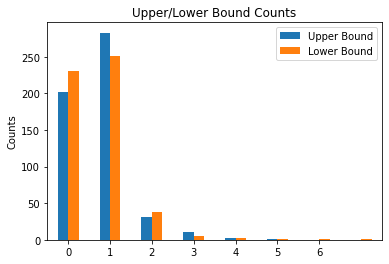

   Upper Bound  Lower Bound
0        202.0          231
1        283.0          251
2         31.0           38
3         11.0            5
4          2.0            2
5          1.0            1
6          NaN            1
7          NaN            1


In [191]:
ULB.plot_counts()

Max = -4
Mean = -21.114285714285714
Median = -15.0
Min = -364
There are 632 Nones.


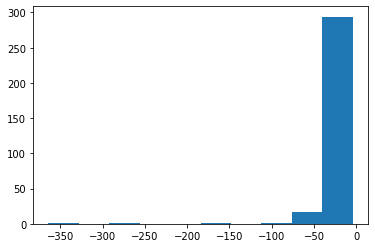

In [222]:
ULB.naive_comparison()